#A mixture of AI and our own code was used here.

In [59]:
# Import required libraries
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [91]:
#Import the training semiconductor dats
df = pd.read_csv('train.csv')

# Randomly select n rows for testing. Used all rows in final optimization
df_sampled = df #df.sample(n=5000, random_state=42)  # set random_state for reproducibility

#Remove all features with 'std' in the name (standard deviation)
df_in = df_sampled.drop(columns=[col for col in df_sampled.columns if 'std' in col or col == 'critical_temp'])

#Obtain critical temperature (output) dataframe
df_out = df_sampled[['critical_temp']]
print(df_in)
print(df_out)

       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                       4         88.944468             57.862692   
1                       5         92.729214             58.518416   
2                       4         88.944468             57.885242   
3                       4         88.944468             57.873967   
4                       4         88.944468             57.840143   
...                   ...               ...                   ...   
21258                   4        106.957877             53.095769   
21259                   5         92.266740             49.021367   
21260                   2         99.663190             95.609104   
21261                   2         99.663190             97.095602   
21262                   3         87.468333             86.858500   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0              66.361592              36.116612             1.181795   
1              73.132787   

PC1: 39.89%
PC2: 12.01%
PC3: 8.89%
PC4: 8.18%
PC5: 6.14%
PC6: 4.31%
PC7: 3.47%
PC8: 2.74%
PC9: 2.00%
PC10: 1.68%
PC11: 1.46%
PC12: 1.36%
PC13: 0.88%
PC14: 0.87%
PC15: 0.80%
PC16: 0.66%
PC17: 0.64%
PC18: 0.56%
PC19: 0.43%
PC20: 0.35%
PC21: 0.33%
PC22: 0.25%
PC23: 0.24%
PC24: 0.22%
PC25: 0.19%
PC26: 0.19%
PC27: 0.13%
PC28: 0.13%
PC29: 0.11%
PC30: 0.10%
PC31: 0.09%
PC32: 0.08%
PC33: 0.07%
PC34: 0.07%
PC35: 0.05%
PC36: 0.05%
PC37: 0.04%
PC38: 0.04%
PC39: 0.03%
PC40: 0.03%
PC41: 0.02%
PC42: 0.02%
PC43: 0.02%
PC44: 0.02%
PC45: 0.02%
PC46: 0.01%
PC47: 0.01%
PC48: 0.01%
PC49: 0.01%
PC50: 0.01%
PC51: 0.01%
PC52: 0.01%
PC53: 0.01%
PC54: 0.01%
PC55: 0.00%
PC56: 0.00%
PC57: 0.00%
PC58: 0.00%
PC59: 0.00%
PC60: 0.00%
PC61: 0.00%
PC62: 0.00%
PC63: 0.00%
PC64: 0.00%
PC65: 0.00%
--------------------------------------------------------------------------------------------------------------
* variance captured by the  65  PCs :  99.99975630417117 %
---------------------------------------------------------

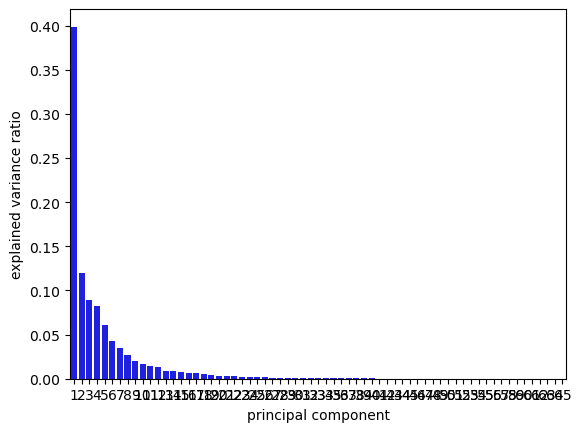

Total variance captured by first 15 components: 94.69%


In [93]:
# Scale input and output
input_scaler = StandardScaler()
output_scaler = StandardScaler()

scaled_inputs = input_scaler.fit_transform(df_in)
scaled_outputs = output_scaler.fit_transform(df_out.values.reshape(-1,1))

#PCA
pca = PCA().fit(scaled_inputs)

#Obtain variance explained for each Principal Component (PC)
for i, evr in enumerate(pca.explained_variance_ratio_):
   print(f"PC{i+1}: {evr:.2%}")
print('-'*110)
print('* variance captured by the ', str(65),' PCs : ',str(np.sum(pca.explained_variance_ratio_[0:64])*100), '%')
print('-'*110)

# Scree plot
fig, ax = plt.subplots()
sns.barplot(x=np.arange(1, len(pca.explained_variance_ratio_)+1),y=pca.explained_variance_ratio_ ,color='blue')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance ratio')
plt.show()

#Reduce Dimensionality to n components
pca_model = PCA(n_components=15)
X_pca = pca_model.fit_transform(scaled_inputs)
y_scaled = scaled_outputs
variance_total = np.sum(pca_model.explained_variance_ratio_[:15]) * 100
print(f"Total variance captured by first 15 components: {variance_total:.2f}%")

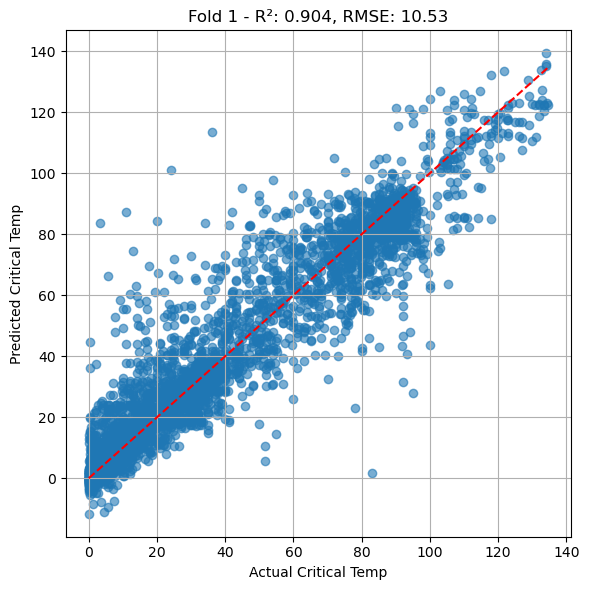

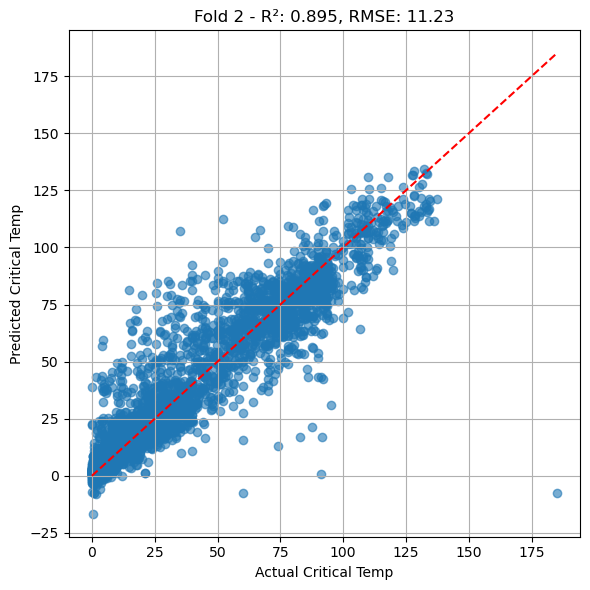

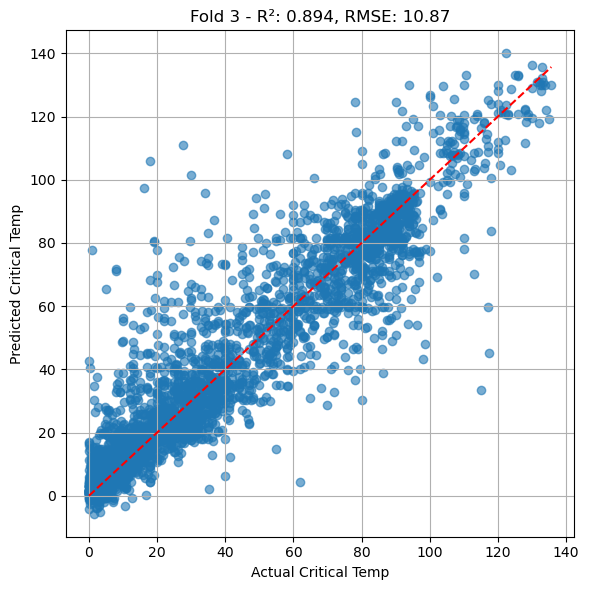

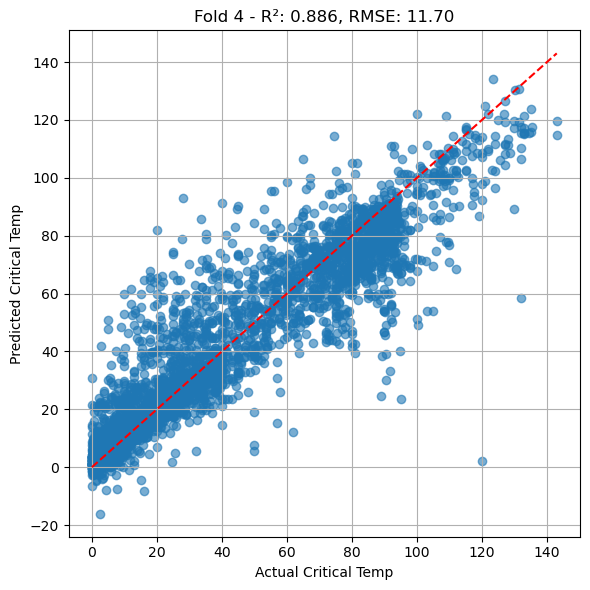

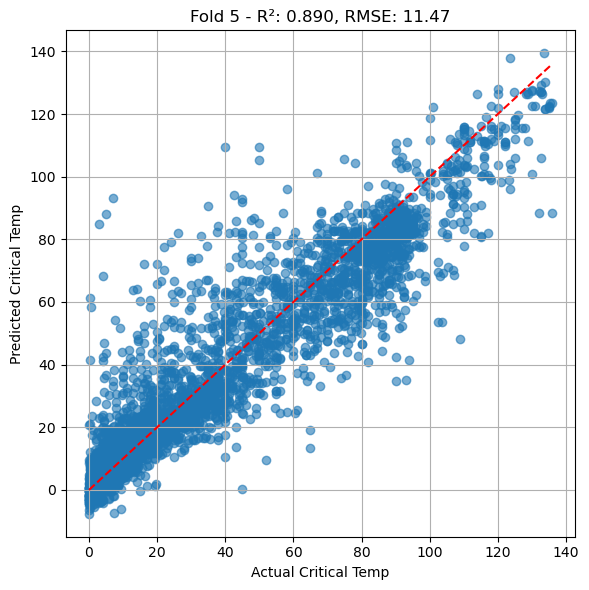

Average R²: 0.894
Average RMSE: 11.16


In [81]:
#Neural network + 5-fold cross validation

# Initialize 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_r2 = []
all_rmse = []

#Perform the fitting with CV
for fold, (train_index, test_index) in enumerate(kf.split(X_pca), start = 1):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]
    
    # Neural network model
    model = MLPRegressor(hidden_layer_sizes=(128, 128, 128), activation='relu', max_iter=1500, random_state=fold, early_stopping=True, alpha = 1e-4, validation_fraction = 0.1)
    model.fit(X_train, y_train.ravel())

    # Predict
    y_pred_scaled = model.predict(X_test)
    y_pred = output_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_true = output_scaler.inverse_transform(y_test)

    # Metrics
    r2 = r2_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    all_r2.append(r2)
    all_rmse.append(rmse)
    
    # Parity plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual Critical Temp')
    plt.ylabel('Predicted Critical Temp')
    plt.title(f'Fold {fold} - R²: {r2:.3f}, RMSE: {rmse:.2f}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
print(f"Average R²: {np.mean(all_r2):.3f}")
print(f"Average RMSE: {np.mean(all_rmse):.2f}")




In [9]:
#####OPTIMIZING IN PCA SPACE NOT CHOSEN IN FINAL#################
from scipy.optimize import minimize

# Objective: Negative prediction (since we want to maximize)
def objective(pca):
    pca_input = np.array(pca).reshape(1, -1)
    pred_scaled = model.predict(pca_input)
    return -pred_scaled[0]  # minimize negative = maximize positive
    
# Bounds for PCA values (can be wide initially)
pca_bounds = [(-5, 5)] * 12

# Initial guess: mean of PCA space
x0 = np.zeros(12)

# Optimize
result = minimize(objective, x0, bounds=pca_bounds, method='L-BFGS-B')

# Optimal PCA input
optimal_pca_input = result.x.reshape(1, -1)

# Step 1: PCA → scaled 65-D input
scaled_input = pca_model.inverse_transform(optimal_pca_input)

# Step 2: scaled → original 65-D input
original_input = input_scaler.inverse_transform(scaled_input)

# Predicted maximum output (unscaled)
pred_scaled = model.predict(optimal_pca_input)
predicted_max_output = output_scaler.inverse_transform(pred_scaled.reshape(-1, 1))
print("Predicted max output:", predicted_max_output[0, 0])

# Create a DataFrame with the optimal input values
optimal_inputs_df = pd.DataFrame(original_input, columns=df_in.columns)

# Print the DataFrame to show variable names with their optimal values
print("Optimal original input features that produce it:")
print(optimal_inputs_df.T)  # Transposed so that variable names are next to their values

Predicted max output: 266.5847418606658
Optimal original input features that produce it:
                               0
number_of_elements      5.163577
mean_atomic_mass       94.507954
wtd_mean_atomic_mass   33.422499
gmean_atomic_mass      60.453925
wtd_gmean_atomic_mass   7.747486
...                          ...
wtd_entropy_Valence     1.164551
range_Valence          -1.633288
wtd_range_Valence       2.370310
std_Valence            -0.557997
wtd_std_Valence        -0.975043

[81 rows x 1 columns]


In [89]:
##############OPTIMIZING IN SCALED SPACE CHOSEN FOR FINAL#################
from scipy.optimize import minimize

# Objective: Maximize output from model
def objective(scaled_input):
    scaled_input = np.array(scaled_input).reshape(1, -1)
    pca_scores = pca_model.transform(scaled_input)
    pred_scaled = model.predict(pca_scores)
    return -pred_scaled[0]  # Maximize predicted output

# Initial guess: mean of scaled inputs (i.e., 0s)
x0 = np.zeros(65)

# Bounds for each input variable in scaled space
scaled_inputs_df = pd.DataFrame(scaled_inputs, columns=df_in.columns, index=df_in.index)
input_bounds = list(zip(scaled_inputs_df.min().values, scaled_inputs_df.max().values))

# Run optimization
result = minimize(objective, x0, bounds=input_bounds, method='L-BFGS-B')

# Convert scaled input → original input
scaled_opt = result.x.reshape(1, -1)
original_input = input_scaler.inverse_transform(scaled_opt)

# Predict maximum output
pca_scores = pca_model.transform(scaled_opt)
pred_scaled = model.predict(pca_scores)
predicted_max_output = output_scaler.inverse_transform(pred_scaled.reshape(-1, 1))

# Show result with variable names
optimal_inputs_df = pd.DataFrame(original_input, columns=df_in.columns)

print("Predicted max output:", predicted_max_output[0, 0])
print("Optimal input values (original scale):")
print(optimal_inputs_df.T)

#Exports final scaled optimization results to excel
optimal_inputs_df.T.to_excel("Scaled_OPT.xlsx", header=False)

Predicted max output: 553.3530007540407
Optimal input values (original scale):
                                0
number_of_elements       9.000000
mean_atomic_mass       208.980400
wtd_mean_atomic_mass   208.786961
gmean_atomic_mass      208.975446
wtd_gmean_atomic_mass   42.368059
...                           ...
wtd_gmean_Valence        1.000000
entropy_Valence          2.141963
wtd_entropy_Valence      1.949739
range_Valence            0.241033
wtd_range_Valence        0.000000

[65 rows x 1 columns]


In [85]:
###########OPTIMIZE IN ORIGINAL SPACE NOT CHOSEN FOR FINAL#############################
from scipy.optimize import minimize

# Objective: Maximize model prediction (minimize the negative)
def objective(original_input):

    # Step 1: scale the input
    original_input = np.array(original_input).reshape(1, -1)
    original_input_df = pd.DataFrame(original_input, columns=df_in.columns)
    scaled_input = input_scaler.transform(original_input_df)

    # Step 2: apply PCA
    pca_input = pca_model.transform(scaled_input)

    # Step 3: predict scaled output from model
    pred_scaled = model.predict(pca_input)

    return -pred_scaled[0]  # minimize the negative = maximize output

# Initial guess: mean of the training data
x0 = df_in.mean().values

# Bounds in original input space
input_bounds = list(zip(df_in.min().values, df_in.max().values))

# Run optimization
result = minimize(objective, x0, bounds=input_bounds, method='L-BFGS-B')

# Extract optimal input and predicted output
optimal_original_input = result.x.reshape(1, -1)

# Step 1: scale
optimal_input_df = pd.DataFrame(optimal_original_input, columns=df_in.columns)
scaled_optimal_input = input_scaler.transform(optimal_input_df)

# Step 2: PCA
pca_optimal_input = pca_model.transform(scaled_optimal_input)

# Step 3: Predict
pred_scaled = model.predict(pca_optimal_input)
predicted_max_output = output_scaler.inverse_transform(pred_scaled.reshape(-1, 1))

# Show results
optimal_inputs_df = pd.DataFrame(optimal_original_input, columns=df_in.columns)

print("Optimization complete.")
print("Predicted max output:", predicted_max_output[0, 0])
print("Optimal original input values that produce it:")
print(optimal_inputs_df.T)

✅ Optimization complete.
Predicted max output: 448.7519261805503
Optimal original input values that produce it:
                                0
number_of_elements       8.318512
mean_atomic_mass       208.980400
wtd_mean_atomic_mass   140.653005
gmean_atomic_mass        9.456063
wtd_gmean_atomic_mass    1.966800
...                           ...
wtd_gmean_Valence        1.000000
entropy_Valence          2.141963
wtd_entropy_Valence      1.949739
range_Valence            0.000000
wtd_range_Valence        0.000000

[65 rows x 1 columns]


In [87]:
#Exports my unscaled optimization results to excel
optimal_inputs_df.T.to_excel("Unscaled_Opt.xlsx", header=False)